In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("Prepared Data.csv")

In [3]:
df[['MemberAge', 'IMD10', 'VisitsPerMonth']].describe()

,MemberAge,IMD10,VisitsPerMonth
count,610193.000000,610193.000000,610193.000000
mean,34.313650,4.905402,4.094942
std,14.170027,2.664490,4.440302
min,0.000000,1.000000,0.000000
25%,24.000000,3.000000,1.048852
50%,32.000000,4.000000,2.698256
75%,42.000000,7.000000,5.603077
max,98.000000,10.000000,49.970300


VisitsPerMonth looks to be heavily skewed so we may need to apply a log transform.

In [4]:
for col in ['Gender', 'Ethnicity', 'IsDisabled', 'MembershipScope', 'IsDiscounted',
            'DiscountType', 'Persona', 'output_area_classification_supergroup', 'UsageType']:
    print(df[col].value_counts(dropna=False), '\n')


Gender
Female        303673
Male          298326
Not Given       8179
Non Binary        15
Name: count, dtype: int64 

Ethnicity
White                                                      298668
Not Given                                                  131229
Asian, Asian British or Asian Welsh                         87129
Black, Black British, Black Welsh, Caribbean or African     50088
Mixed or Multiple ethnic groups                             22136
Other ethnic group                                          20943
Name: count, dtype: int64 

IsDisabled
No           571349
Yes           30537
Not Given      8307
Name: count, dtype: int64 

MembershipScope
Centre         304838
Partnership    153195
National        77969
Other           74191
Name: count, dtype: int64 

IsDiscounted
No     409604
Yes    200589
Name: count, dtype: int64 

DiscountType
No Discount      409604
Student           89473
Corporate         45911
Disability        19502
Concessionary     18943
GP Referral   

Non-binary is too small category so will need to be combined with 'Not Given'. 'Carer' and 'GSF' DiscountTypes may also need to be combined as are small.

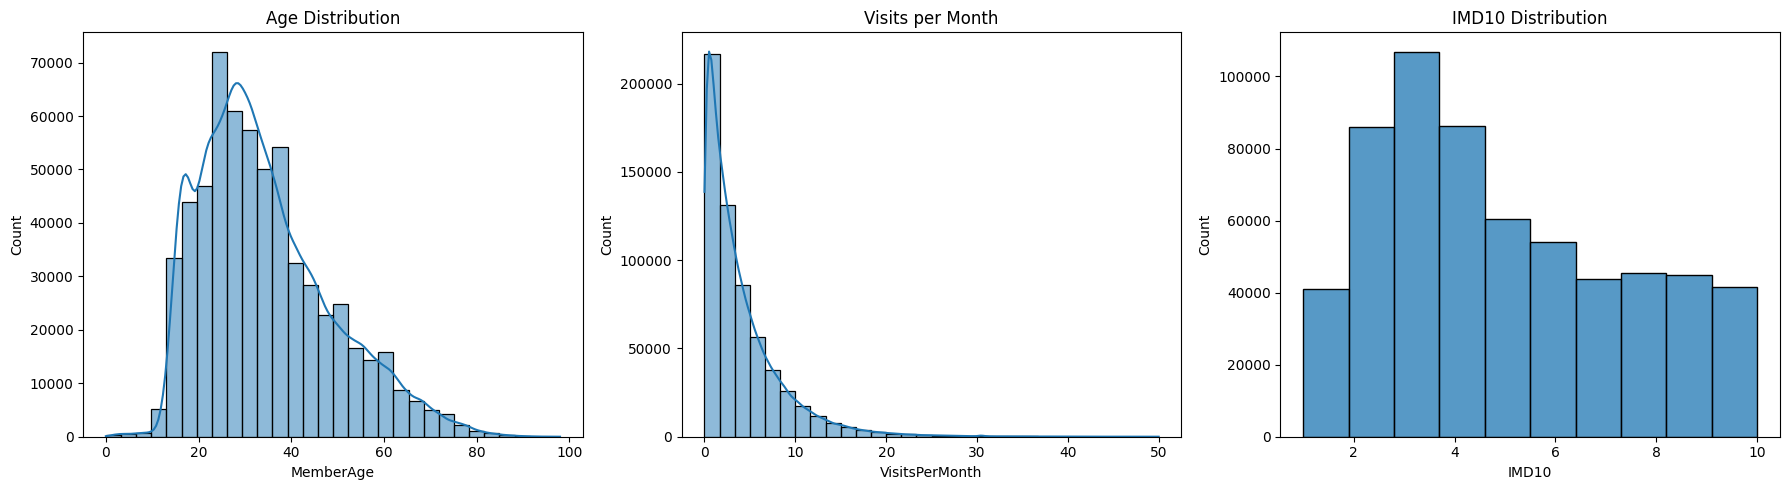

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot 1: Age
sns.histplot(df['MemberAge'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')

# Plot 2: Visits per Month
sns.histplot(df['VisitsPerMonth'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Visits per Month')

# Plot 3: IMD10
sns.histplot(df['IMD10'], bins=10, kde=False, ax=axes[2])
axes[2].set_title('IMD10 Distribution')

plt.tight_layout()
plt.show()

In [6]:
# Add column for log VisitsPerMonth
df["log VisitsPerMonth"] = np.log1p(df["VisitsPerMonth"])

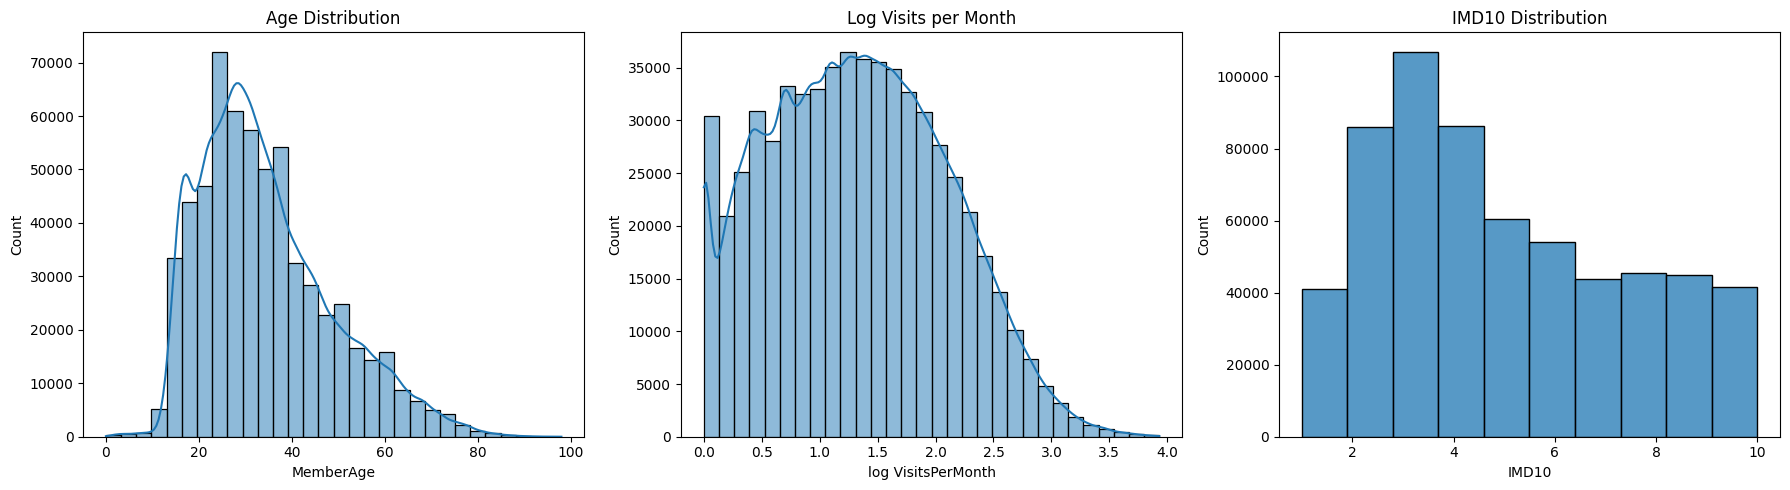

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot 1: Age
sns.histplot(df['MemberAge'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')

# Plot 2: log Visits per Month
sns.histplot(df['log VisitsPerMonth'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log Visits per Month')

# Plot 3: IMD10
sns.histplot(df['IMD10'], bins=10, kde=False, ax=axes[2])
axes[2].set_title('IMD10 Distribution')

plt.tight_layout()
plt.show()

Visits per Month is better now.

In [8]:
pd.crosstab(df['Gender'], df['UsageType'], normalize='index')

UsageType,Fitness Class,Gym,Mixed,Other,Swim
Gender,,,,,
Female,0.175814,0.524357,0.082780,0.035907,0.181142
Male,0.018403,0.734760,0.041994,0.046885,0.157958
Non Binary,0.000000,0.666667,0.133333,0.066667,0.133333
Not Given,0.084607,0.609610,0.065534,0.057342,0.182907


In [9]:
# Group non-binary and not given gender
df['Gender'] = df['Gender'].replace({
    'Non Binary': 'Non Binary / Not Given',
    'Not Given': 'Non Binary / Not Given'
})

# Group GSF and Carer into 'Other'
df['DiscountType'] = df['DiscountType'].replace({
    'GSF': 'Other',
    'Carer': 'Other'
})


Drop Persona due to large amount of data missing.

In [10]:
# One-hot encode
factor_variables = ['Gender', 'Ethnicity', 'IsDisabled', 'MembershipScope', 'IsDiscounted',
            'DiscountType', 'output_area_classification_supergroup', 'UsageType']
df_encoded = pd.get_dummies(df[factor_variables], drop_first=True)

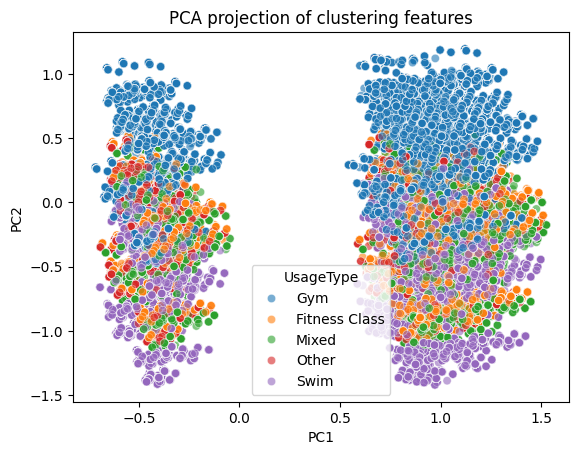

In [13]:
from sklearn.decomposition import PCA

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_encoded)

# Add PCA results to your dataframe
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]

sns.scatterplot(data=df, x='PC1', y='PC2', hue='UsageType', alpha=0.6)
plt.title('PCA projection of clustering features')
plt.show()


In [12]:
continuous_variables = ['MemberAge', 'IMD10', 'log VisitsPerMonth']

df_cluster_input = pd.concat([df[continuous_variables], df_encoded, df[['Id', 'LengthOfStayInMonths']]], axis=1)

#scaler = StandardScaler()
#df_cluster_input[continuous_variables] = scaler.fit_transform(df_cluster_input[continuous_variables])

df_cluster_input.to_csv("Clustering Data.csv", index = False)